In [1]:
### Kütüphanelerin dahil edilmesi
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sbn

In [3]:
# CSV dosyasının yüklenmesi
metadata = pd.read_csv(r'C:\Users\menes\Veri Bilimi\UrbanSoundClassification8k\UrbanSound8K.csv')

### Verinin incelenmesi

In [5]:
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [7]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [9]:
metadata.isna().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [11]:
# UrbanSoundClassification8k Veri setinde bulunan sınıflar
class_values = {
    "air_conditioner":0,
    "car_hor":1,
    "children_playing":2,
    "dog_bark":3,
    "drilling":4,
    "engine_idling" : 5,
    "gun_shot":6,
    "jackhammer":7,
    "siren":8,
    "street_music":9,
}

In [13]:
correlation_matrix = metadata[['start','end','salience', 'fold']].corr()
print(correlation_matrix)

             start       end  salience      fold
start     1.000000  0.999915  0.137844 -0.067839
end       0.999915  1.000000  0.138702 -0.067625
salience  0.137844  0.138702  1.000000 -0.013724
fold     -0.067839 -0.067625 -0.013724  1.000000


### Ses verisini görselleştirme ve sınıflardan örnekler alarak sesleri inceleme

Toplam 8732 ses verisi yüklendi.


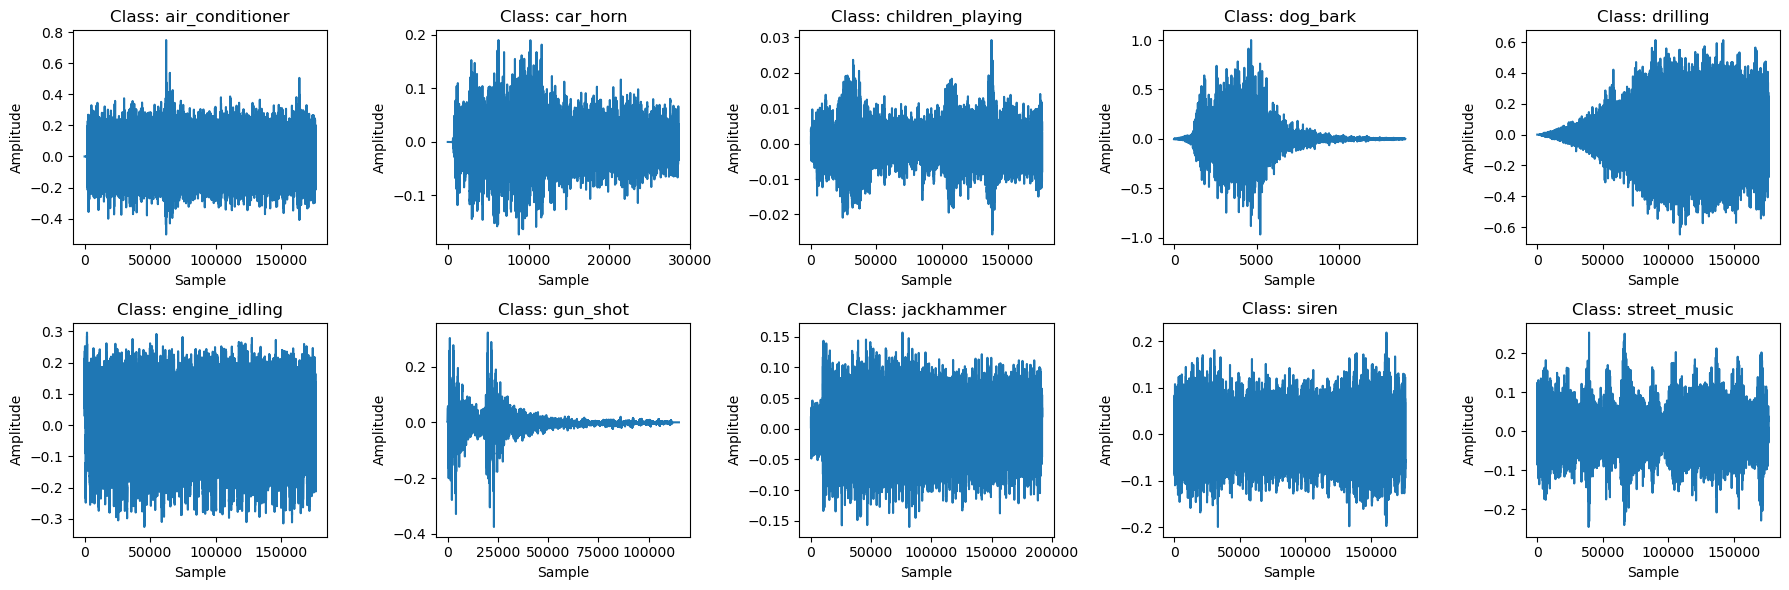

In [15]:

# Ses dosyalarını ve sınıf etiketlerini yükleme fonksiyonu
def load_audio_data(dataset_dir, metadata):
    audio_data = []
    
    # Her satırdaki dosya ve classID bilgilerini dolaş
    for index, row in metadata.iterrows():
        file_name = row['slice_file_name']
        fold = row['fold']
        class_id = row['classID']
        
        # Ses dosyasının tam yolunu oluştur
        file_path = os.path.join(dataset_dir, f'fold{fold}', file_name)
        
        # Ses dosyasını yükle (y: dalga formu, sr: örnekleme oranı)
        try:
            y, sr = librosa.load(file_path, sr=None)
            # audio_data listesine dalga formu ve classID ekle
            audio_data.append((y, class_id))
        except Exception as e:
            print(f"{file_name} yüklenirken hata oluştu: {e}")
    
    return audio_data

# Ses dosyalarının bulunduğu dizin
urban_sound_dir = r'C:\Users\menes\Veri Bilimi\UrbanSoundClassification8k\audio'    

# Tüm ses dosyalarını yükle ve ses dosyalarının yüklendiğinden emin olun
audio_data = load_audio_data(urban_sound_dir, metadata)

# Audio data'nın dolu olup olmadığını kontrol edin
if not audio_data:
    print("Ses verileri yüklenemedi, liste boş!")
else:
    print(f"Toplam {len(audio_data)} ses verisi yüklendi.")

# Her sınıftan bir örnek almak için fonksiyon
def get_samples_from_each_class(audio_data):
    samples_by_class = {}
    for waveform, class_id in audio_data:
        class_name = metadata[metadata['classID'] == class_id]['class'].iloc[0]
        if class_name not in samples_by_class:
            samples_by_class[class_name] = waveform
    return samples_by_class

# Her sınıftan bir örnek al
samples_by_class = get_samples_from_each_class(audio_data)

# Sınıf adlarına göre örnekleri sıralayın
samples_by_class_sorted = dict(sorted(samples_by_class.items()))

# Her sınıftan bir örneği görselleştiren fonksiyon
def plot_samples_from_each_class(samples_by_class_sorted):
    num_classes = len(samples_by_class_sorted)
    plt.figure(figsize=(18, 6))
    for i, (class_name, waveform) in enumerate(samples_by_class_sorted.items(), start=1):
        plt.subplot(2, (num_classes + 1) // 2, i)
        
        # Dalga formunu doğrudan çizin (numpy'a çevirme gerek yok)
        plt.plot(waveform)
        plt.title(f"Class: {class_name}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

# Her sınıftan bir örneği görselleştir
plot_samples_from_each_class(samples_by_class_sorted)


In [17]:
# Her sınıftan rastgele ses dosyası alıp oynatacak fonksiyon
def play_random_audio_samples_by_class(metadata, dataset_dir):
    # Sınıfları elde et
    classes = metadata['class'].unique()
    
    for class_name in classes:
        # Bu sınıfa ait tüm satırları seç
        class_files = metadata[metadata['class'] == class_name]
        
        # Rastgele bir dosya seç
        random_sample = class_files.sample(1)
        file_name = random_sample['slice_file_name'].values[0]
        fold = random_sample['fold'].values[0]  # Hangi fold içinde olduğunu öğren
        
        # Dosya yolunu oluştur
        file_path = os.path.join(dataset_dir, f'fold{fold}', file_name)
        
        # Dosyayı yükle ve oynat
        print(f"Playing audio sample for class: {class_name} from fold {fold}")
        y, sr = librosa.load(file_path, sr=None)
        ipd.display(ipd.Audio(y, rate=sr))

# UrbanSound veri setinin bulunduğu klasör
urban_sound_dir = r'C:\Users\menes\Veri Bilimi\UrbanSoundClassification8k\audio'

# Rasgele örnekler çal
play_random_audio_samples_by_class(metadata, urban_sound_dir)


Playing audio sample for class: dog_bark from fold 8


Playing audio sample for class: children_playing from fold 2


Playing audio sample for class: car_horn from fold 5


Playing audio sample for class: air_conditioner from fold 3


Playing audio sample for class: street_music from fold 3


Playing audio sample for class: gun_shot from fold 2


Playing audio sample for class: siren from fold 4


Playing audio sample for class: engine_idling from fold 7


Playing audio sample for class: jackhammer from fold 4


Playing audio sample for class: drilling from fold 3


### Model oluşturma

In [19]:
# Model eğitimi için gerekli kütüphanelerin dahil edilmesi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tqdm import tqdm

MFCC ile özellik çıkarımı:

MFCC (Mel-Frekans Kepstrum Katsayıları), ses sinyallerinin insan kulağının frekans duyarlılığına benzer şekilde işlenmesini sağlayan bir özellik çıkarma yöntemidir. Ses sinyalini frekans bileşenlerine ayırır, ölçekler ve sıkıştırarak kullanıma uygun hale getirir. Özellikle konuşma tanıma, müzik sınıflandırma ve konuşma sentezinde yaygın olarak kullanılır. MFCC, konuşma tanıma gibi uygulamalarda kritik bir rol oynar.

Kaynak : https://efecanxrd.medium.com/mfcc-mel-frequency-cepstral-coefficients-ve-gmm-gaussian-mixture-model-teknikleri-f81a2cc632a5

In [21]:
from librosa import resample

def feature_extractor(file):
    audio, sample_rate = librosa.load(file, sr=None)
    audio_resampled = resample(audio, orig_sr=sample_rate, target_sr=22050)
    
    # n_fft'yi sinyalin uzunluğuna göre ayarla
    n_fft = min(len(audio_resampled), 2048)  # 2048 veya sinyal uzunluğunun küçük olanı
    mfccs_features = librosa.feature.mfcc(y=audio_resampled, sr=22050, n_mfcc=40, n_fft=n_fft)
    
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


extracted_features = []

for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(
        os.path.abspath(urban_sound_dir), 
        "fold" + str(row["fold"]) + "/" + str(row["slice_file_name"])
    )
    final_class_label = row["class"]
    
    data = feature_extractor(file_name)
    extracted_features.append([data, final_class_label])


8732it [02:00, 72.40it/s] 


In [23]:
extracted_features_df = pd.DataFrame(extracted_features,columns=["features","class"])
extracted_features_df.head()

features             class
0  [-211.93698, 62.581207, -122.81313, -60.745293...          dog_bark
1  [-417.0052, 99.336624, -42.995586, 51.073326, ...  children_playing
2  [-452.39316, 112.36253, -37.578068, 43.19586, ...  children_playing
3  [-406.47922, 91.1966, -25.043556, 42.78452, 11...  children_playing
4  [-439.63873, 103.86223, -42.658787, 50.690277,...  children_playing

In [25]:
x = np.array(extracted_features_df["features"].to_list())
y = np.array(extracted_features_df["class"].to_list())

In [27]:
print(y.shape)
print(x.shape)

(8732,)
(8732, 40)


In [29]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [31]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
num_labels = 10

""" 

x ve y olarak veri ve etiket olarak ayrıldı. Array formatına çevrildi. Etiket verileri numerik olacak şekilde LabelEncoder yöntemiyle modele verilmeye uygun hale getirildi.

"""

In [35]:
print(type(x_train), x_train.shape, x_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)
print(type(x_test), x_test.shape, x_test.dtype)
print(type(y_test), y_test.shape, y_test.dtype)


<class 'numpy.ndarray'> (6985, 40) float32
<class 'numpy.ndarray'> (6985, 10) float64
<class 'numpy.ndarray'> (1747, 40) float32
<class 'numpy.ndarray'> (1747, 10) float64


### Derin sinir ağı oluşturma

In [37]:
# Model tanımlama
model = Sequential([
    layers.Input(shape=(40,)),  # Giriş boyutu 40
    
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),  ## -->> Her minibatch'i normalize ederek modelin aşırı öğrenmesini azaltır, ayrıca eğitim hızını da artırır.
    layers.Dropout(0.2),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(10, activation='softmax')
])





In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,896,202 (11.05 MB)

 Trainable params: 2,888,138 (11.02 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [41]:
# Model derleme
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
# patience = 2 --->> modelin eğitim sürecinde 2 epoch iyileşme olmazsa eğitim durdurulur. Böylelikle aşırı öğrenme sorunu minimize edilir.
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [45]:
num_batch_size = 32
num_epochs = 300

In [47]:
history = model.fit(x_train, y_train, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stopping],  # EarlyStopping callback'i ekleniyor
                    verbose=1)

Epoch 1/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2994 - loss: 2.1549 - val_accuracy: 0.5890 - val_loss: 1.2676
Epoch 2/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5176 - loss: 1.4388 - val_accuracy: 0.6451 - val_loss: 1.0290
Epoch 3/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6073 - loss: 1.2070 - val_accuracy: 0.6886 - val_loss: 0.9457
Epoch 4/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6396 - loss: 1.0846 - val_accuracy: 0.7270 - val_loss: 0.8155
Epoch 5/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6918 - loss: 0.9527 - val_accuracy: 0.7705 - val_loss: 0.7247
Epoch 6/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7141 - loss: 0.8786 - val_accuracy: 0.7647 - val_loss: 0.7070
Epoch 7/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7355 - loss: 0.8091 - val_accuracy: 0.7808 - val_loss: 0.6881
Epoch 8/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7581 - loss: 0.7460 -

In [49]:
val_acc = model.evaluate(x_test,y_test,verbose=0)
print(val_acc[1])

0.8465941548347473


In [51]:
# Spesifik ses dosyasının yolu
file_name = "C:\\Users\\..... (.wav uzantılı dosyanın yolu).wav"

## --->> Modele tahmin yaptırmak için seçilen bir .wav uzantılı dosya mfcc özellik çıkarımına tabi tutulur 

# Orijinal sample rate'te yükleme
audio, sample_rate = librosa.load(file_name, sr=None)

# Hedef sample rate'e yeniden örnekleme (22050 Hz) - librosa kullanımı
audio_resampled = librosa.resample(audio, orig_sr=sample_rate, target_sr=22050)

# MFCC özellikleri çıkarma
mfccs_features = librosa.feature.mfcc(y=audio_resampled, sr=22050, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)


In [53]:
mfccs_scaled_features

array([-111.88043   ,   17.417416  ,  -43.437267  ,   26.932634  ,
         -1.7675707 ,   -5.3738246 ,   -2.3229356 ,   11.985293  ,
         -1.1778636 ,    0.7516741 ,    0.72778535,    1.9218975 ,
        -11.308579  ,   -8.263459  ,  -14.641377  ,   -4.1225896 ,
        -12.667436  ,    3.9149632 ,   -1.5669224 ,   -1.2340863 ,
         -4.050786  ,    5.844613  ,   -0.7802057 ,   -8.8667755 ,
         -2.0131052 ,    3.347067  ,   -5.474802  ,    4.7882886 ,
          2.6604455 ,    5.470943  ,    8.085681  ,    9.2081175 ,
         -1.5005271 ,    0.2097332 ,   -5.024027  ,    2.2458112 ,
         -2.4404538 ,    4.086624  ,   -2.2942674 ,   -0.4090739 ],
      dtype=float32)

In [55]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

In [57]:
mfccs_scaled_features.shape

(1, 40)

In [59]:
result_array = model.predict(mfccs_scaled_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


In [61]:
result_array

array([[1.9643967e-05, 5.5723195e-04, 2.3386671e-04, 3.9306929e-04,
        9.9615222e-01, 9.2950737e-05, 1.4573443e-04, 2.1107362e-03,
        1.0002903e-04, 1.9441759e-04]], dtype=float32)

In [63]:
result_class = list(class_values.keys())
result_class

['air_conditioner',
 'car_hor',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

In [65]:
result = np.argmax(result_array[0])
result_class[result]

'drilling'

In [67]:
ipd.display(ipd.Audio("C:\\Users\\..... (.wav uzantılı dosyanın yolu).wav"))

In [81]:
## TAHMİN VE SESİ GETİREN FONKSİYON

def predict_feature(file):
    audio, sample_rate = librosa.load(file, sr=None)
    audio_resampled = librosa.resample(audio, orig_sr=sample_rate, target_sr=22050)
    mfccs_features = librosa.feature.mfcc(y=audio_resampled, sr=22050, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)
    result_array_def = model.predict(mfccs_scaled_features)
    ipd.display(ipd.Audio(file))
    result = np.argmax(result_array_def[0])
    print("predict : ",result_class[result])
    return result_array_def

res_arr = predict_feature("C:\\Users\\..... (.wav uzantılı dosyanın yolu).wav")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


predict :  dog_bark


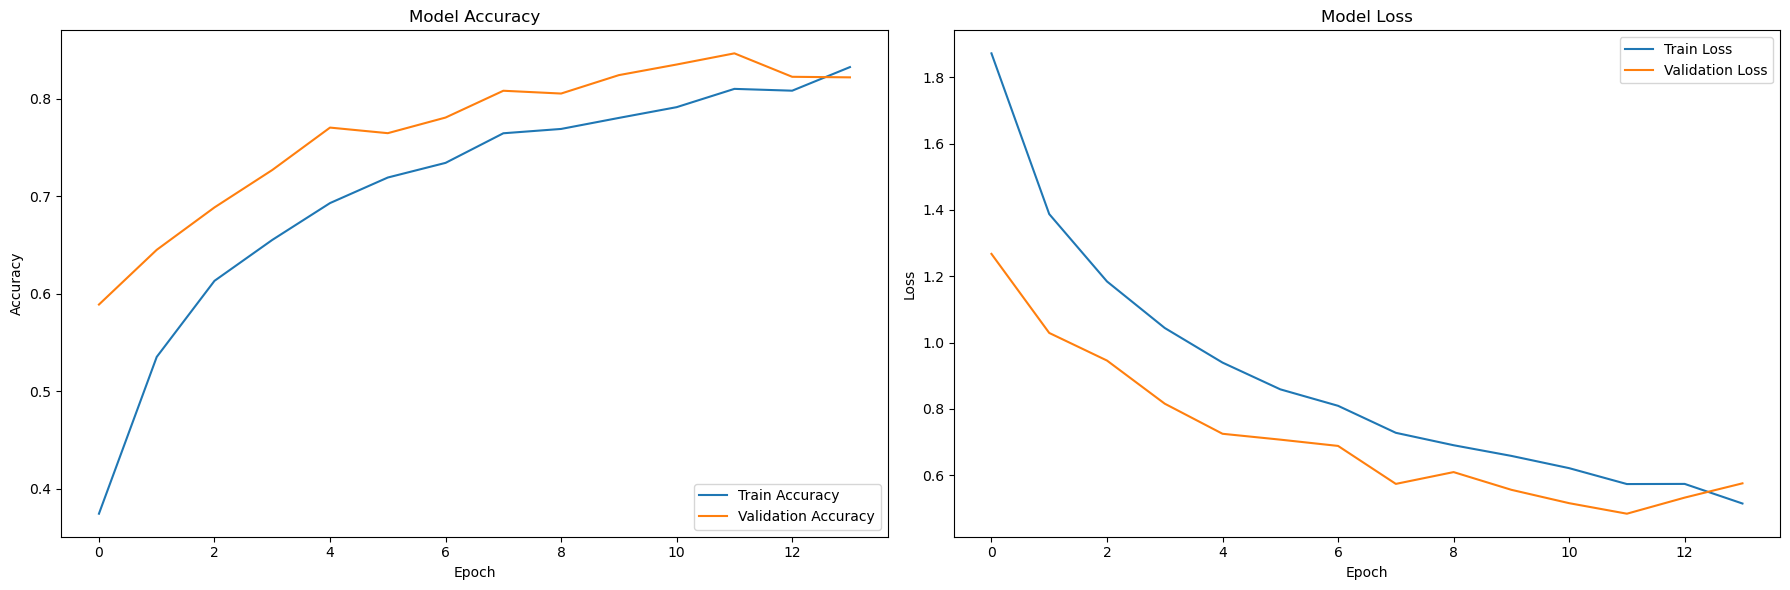

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot eğitim & doğrulama doğruluk değerleri 
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot eğitim & doğrulama loss(kayıp) değerleri 
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [91]:
# Modeli kaydet
model.save('USC_model.keras')

In [93]:
from tensorflow.keras.models import load_model
loaded_model = load_model("USC_model.keras")

C:\Users\menes\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [95]:
# optimizer fonksiyonlarında problem olursa model derlenmeden kaydedilip sonradan derlenebilir.
loaded_model = load_model('USC_model.keras', compile=False)

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


### Sonuç olarak :
Model %84 doğruluk oranına ulaşmış durumda.
Model loss grafiğine bakıldığında validation loss değerinin düzenli bir azalma göstermemesi aşırı öğrenmenin olabileceğini belirtiyor.
Bunun dışında earlystopping ve dropout gibi işlemler uygulamak aşırı öğrenmenin düzeyini azaltmıştır.